<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/UN_decade_banner.png' align='right' width='100%'/>

<a href="../../../Index.ipynb"><< Index</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT <br>
**Authors:** B. Loveday (Innoflair UG / EUMETSAT), Hayley Evers-King (EUMETSAT)

<div class="alert alert-block alert-success">
<h3>Ocean case studies</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>

This notebook has the following prerequisites:
- **<a href="https://eoportal.eumetsat.int/" target="_blank">A EUMETSAT Earth Observation Portal account</a>** to download data from the EUMETSAT Data Store
- **<a href="https://my.wekeo.eu/user-registration" target="_blank">A WEkEO account</a>** to download from WEkEO
    
There are no prerequisite notebooks for this module, but you may wish to look at the following notebooks on using SLSTR data; <br>
- **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-SLSTR" target="_blank">Learn SLSTR (EUMETSAT Gitlab)</a>**

For more contextual information, users should refer to the following case study where the image we generate here is published:
- **<a href="https://www.eumetsat.int/Marine-heatwave-intensification-threatens-coral-reef-health" target="_blank">Marine heatwave intensification threatens coral reef health</a>**

</div>
<hr>

# Marine heatwave intensification threatens coral reef health
<font color="#138D75">**UN Ocean Decade Challenge 2: Protect and restore ecosystems and biodiversity**</font>

### Data used

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 SLSTR level-2 | EO:EUM:DAT:0412 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SL_2_SST?query=SLSTR&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:SL_2_WST___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASL_2_WST___&initial=1" target="_blank">link</a> |
| Global OSTIA SST (Reprocessed) | - | - | EO:MO:DAT:SST_GLO_SST_L4_REP_OBSERVATIONS_010_011 | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AMO%3ADAT%3ASST_GLO_SST_L4_REP_OBSERVATIONS_010_011" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know how to;
* download SLSTR Level-2 SST products from the EUMETSAT Data Store
* spatially plot SLSTR data for the Great Barrier Reef (GBR) region
* download OSTIA reprocessed SST data from WEkEO using the harmonised data access (HDA) API
* make a "climate stripes" plot over the GBR region
* check for marine heat waves in the GBR region

### Outline

@Hayley; UNOD discussion here ....

This code will replicate figures 2, 5 and 6 from the following case study; **<a href="https://www.eumetsat.int/Marine-heatwave-intensification-threatens-coral-reef-health" target="_blank">Marine heatwave intensification threatens coral reef health</a>**.

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Acquiring SLSTR data from the EUMETSAT Data Store](#section1)
 1. [Plotting SLSTR data spatially](#section2)
 1. [Downloading OSTIA SST data via the WEkEO HDA](#section3)
 1. [Preparing the OSTIA data](#section4)
 1. [Making SST-based climate stripes](#section5)
 1. [Testing for marine heatwaves](#section6)

<hr>

In [3]:
import cartopy.crs as ccrs      # a library that supports mapping and projection
import cartopy.feature as ccf   # a cartopy extension that support adding features, e.g. coastlines
import datetime                 # a library that allows us to work with dates and times
import glob                     # a package that helps with file searching
import json                     # a library that helps us make JSON format files
import matplotlib.pyplot as plt # a library the provides plotting capability
from matplotlib import gridspec # a library the provides plotting capability
import netCDF4 as nc            # a library the supports netCDF file read/write
import numpy as np              # a library that lets us work with arrays; we import this with a new name "np"
import os                       # a library that allows us access to basic operating system commands
from shapely import geometry    # a library that support construction of geometry objects
import shutil                   # a library that allows us access to basic operating system commands like copy
import sys                      # a library that gives us access to OS system functions
import xarray as xr             # a powerful library that helps us work efficiently with multi-dimensional arrays
import zipfile                  # a library that allows us to unzip zip-files.
import eumartools               # a library that helps us work with Sentinel-3 data
import eumdac                   # a tool that helps us download via the eumetsat/data-store
from hda import Client          # a library for downloading via wekeo

The following library supports the detection of marine heat waves. More information is available at the following links:

- **<a href="https://github.com/coecms/xmhw" target="_blank">The imported package</a>**
- **<a href="https://github.com/ecjoliver/marineHeatWave" target="_blank">The original development package by Eric Oliver (not imported here)</a>**
- **<a href="https://www.sciencedirect.com/science/article/abs/pii/S0079661116000057?casa_token=k4Z_r0jQNNkAAAAA:Z1aQSNHpiGFC0OJMYfmCuCGCQ_DOqymmhwz0FWDChKh_nsCrm1WKGNWfsBH7CzwKpWUCfDbPXSw" target="_blank">The supporting reference (Hobday et al., 2016)</a>**

In [4]:
from xmhw.xmhw import detect, threshold

We will also create a directory to download our data to. We will be downloading ~3 Gb worth of Level-2 SLSTR SST products and CMEMS OSTIA reprocessed SST products. We will process some of this "on the fly" to reduce local space requirements. The output of this processing will be stored in the `precomputed` directory, which we will also create below.

In [5]:
# Create a download and precomputed directory for our SLSTR and CMEMS products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

precomputed_dir = os.path.join(os.getcwd(), "precomputed")
os.makedirs(precomputed_dir, exist_ok=True)

We will also define a regions over which to plot our SLSTR SST products and extract our OSTIA SST data.

In [6]:
# plot region for SLSTR data: W, E, S, N
plot_region = [142, 156, -25, -10]
# sub-sampling for SLSTR pre-processing
plot_data_subsample = 1

# OSTIA MHW region E, S, W, N
MHW_region = [142, -21, 152, -11]
start_year, end_year, iter_year = [1992, 2021, 5]

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC_TOP)

</div>

Before we begin, we will define one short function that manages the pre-processing of our SLSTR data. This will extract only the variables we need (sea_surface_temperature, sses_bias, quality_level) only over the region we defined above, and applying our subsampling as required. Later, we will call this function as part of our download process.

In [5]:
def process_SST_granule(SST_file, region, subsample=1, quality_level=4):
    '''
     Quick function to process Level-2 SLSTR granules for memory management. 
     Regionally subsets, applies bias and masks out values lower than the quality level.
    '''
    SST_data = xr.open_dataset(SST_file)
    ext_x, ext_y, ext_mask = eumartools.subset_image(SST_data["lon"], SST_data["lat"], 
                                             [region[0], region[1], region[1], region[0]],
                                             [region[2], region[2], region[3], region[3]],
                                             mode='global')
    
    bias_corr_QC_SST = np.array(SST_data["sea_surface_temperature"] + SST_data["sses_bias"] - 273.15)
    bias_corr_QC_SST[np.array(SST_data["quality_level"]) < 4] = np.nan
    
    lon = np.squeeze(np.array(SST_data["lon"]))[np.nanmin(ext_y):np.nanmax(ext_y):subsample,
                                                np.nanmin(ext_x):np.nanmax(ext_x):subsample]
    lat = np.squeeze(np.array(SST_data["lat"]))[np.nanmin(ext_y):np.nanmax(ext_y):subsample,
                                                np.nanmin(ext_x):np.nanmax(ext_x):subsample]
    bias_corr_QC_SST = np.squeeze(bias_corr_QC_SST)[np.nanmin(ext_y):np.nanmax(ext_y):subsample,
                                                    np.nanmin(ext_x):np.nanmax(ext_x):subsample]
    SST_data.close()

    return lon, lat, bias_corr_QC_SST

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Acquiring SLSTR data from the EUMETSAT Data Store
[Back to top](#TOC_TOP)

</div>

We are going to retrieve the SLSTR data from the EUMETSAT Data Store. Collections are stored according to their `collection id`, which for SLSTR Level-2 products is `EO:EUM:DAT:0412` (as specified in the *Data Used* section above). We will also provide the relevant products we want from this collection, stored in `product_list`, which in this case is four granules corresponding to night-time SST over the eastern tropical pacific. For more information on how to search for the data you want, please see the Learn SLSTR Gitlab link above.

In [6]:
collection_id = 'EO:EUM:DAT:0412'
product_list = [
'S3A_SL_2_WST____20211222T123736_20211222T141835_20211223T225541_6059_080_066______MAR_O_NT_003.SEN3',
'S3B_SL_2_WST____20211222T115815_20211222T133915_20211223T224804_6059_060_308______MAR_O_NT_003.SEN3'
]

To access Sentinel-3 data from the <a href="https://data.eumetsat.int">EUMETSAT Data Store</a>, we will use the EUMETSAT Data Access Client (`eumdac`). If you are working with the recommended Anaconda Python distribution and used the supplied environment file (environment.yml) to build this python environment (as detailed in the README), you will already have installed this. If not, you can install eumdac using;

`conda install -c eumetsat eumdac`

However, you can also find the source code on the <a href="https://gitlab.eumetsat.int/eumetlab/data-services/eumdac">EUMETSAT gitlab</a>. Please visit the EUMETSAT user support confluence spaces for the the <a href="https://eumetsatspace.atlassian.net/wiki/spaces/DSDS/overview">Data Store</a> and <a href="https://eumetsatspace.atlassian.net/wiki/spaces/EUMDAC/overview">eumdac</a> for more information.

In order to allow us to download data from the Data Store via API, we need to provide our credentials. We can do this in two ways; either by creating a file called `.eumdac_credentials` in our home directory (*option 1 - recommended*) or by supplying our credentials directly in this script (*option 2*). 

#### Option 1: creating  `.eumdac_credentials` in our home directory

For most computer systems the home directory can be found at the path \user\username, /users/username, or /home/username depending on your operating system.

In this file we need to add the following information exactly as follows;

```
{
"consumer_key": "<your_consumer_key>",
"consumer_secret": "<your_consumer_secret>"
}
```

You must replace `<your_consumer_key>` and `<your_consumer_secret>` with the information you extract from https://api.eumetsat.int/api-key/. You will need a <a href="https://eoportal.eumetsat.int/">EUMETSAT Earth Observation Portal account</a> to access this link, and in order to see the information you must click the "Show hidden fields" button at the bottom of the page.

*Note: your key and secret are permanent, so you only need to do this once, but you should take care to never share them*

Make sure to save the file without any kind of extension. Once you have done this, you can read in your credentials using the commands in the following cell. These will be used to generate a time-limited token, which will refresh itself when it expires.

<div class="alert alert-warning" role="alert">
Optionally, you can provide your credentials directly as follows;
<br>

    
`token = eumdac.AccessToken((consumer_key, consumer_secret))`

<br> 
Note: this method is convenient in the short term, but is not really recommended as you have to put your key and secret in this notebook, and run the risk of accidentally sharing them. This method also requires you to authenticate on a notebook-by-notebook basis.

In [7]:
with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
    credentials = json.load(json_file)
    token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
    print(f"This token '{token}' expires {token.expiration}")

This token '5ad4b23c-9d84-3851-a526-9d124021ffe9' expires 2022-07-24 21:38:09.340217


Now we have a token, we can create an instance of the EUMETSAT Data Store.

In [8]:
datastore = eumdac.DataStore(token)

We can use this instance to search for products, but in our case we already know the ones we want (as listed in `products_list`), so we can download them directly. Once we have downloaded a granule, we will also subset the file and strip out any variables we don't need to save local storage space. This will be stored in the `precomputed` directory.

In [9]:
for product in product_list:
    selected_product = datastore.get_product(product_id=product, collection_id=collection_id)
    print(f"Downloading and unzipping:\n>> {product}")

    with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)

    with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(str(product)):
                zip_ref.extract(file, download_dir)

    # remove zip file
    os.remove(fdst.name)

    # process downloaded file
    SST_file = glob.glob(os.path.join(download_dir, product, "*.nc"))[0]
    OUT_file = os.path.join(precomputed_dir, product.replace('.SEN3','_subset.nc'))
    lon, lat, sst = process_SST_granule(SST_file, plot_region, subsample=plot_data_subsample)

    # write to new netCDF file
    ds = xr.Dataset({"sst": (("x", "y"), sst)},
                    coords={"lat": (("x", "y"), lat), 
                            "lon": (("x", "y"), lon)})
    ds.to_netcdf(OUT_file, format='NETCDF4_CLASSIC')
    
    # remove full size download
    shutil.rmtree(os.path.join(download_dir, product))

>> S3A_SL_2_WST____20211222T123736_20211222T141835_20211223T225541_6059_080_066______MAR_O_NT_003.SEN3
>> S3B_SL_2_WST____20211222T115815_20211222T133915_20211223T224804_6059_060_308______MAR_O_NT_003.SEN3


/Users/benloveday/opt/anaconda3/envs/cmts_ocean_case_studies/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Plotting SLSTR data spatially
[Back to top](#TOC_TOP)

</div>

Lets start by collecting our Level-2 SLSTR SST products

In [10]:
# get the files
SLSTR_files = glob.glob(os.path.join(precomputed_dir, '*.nc'))

And now we can make our plot

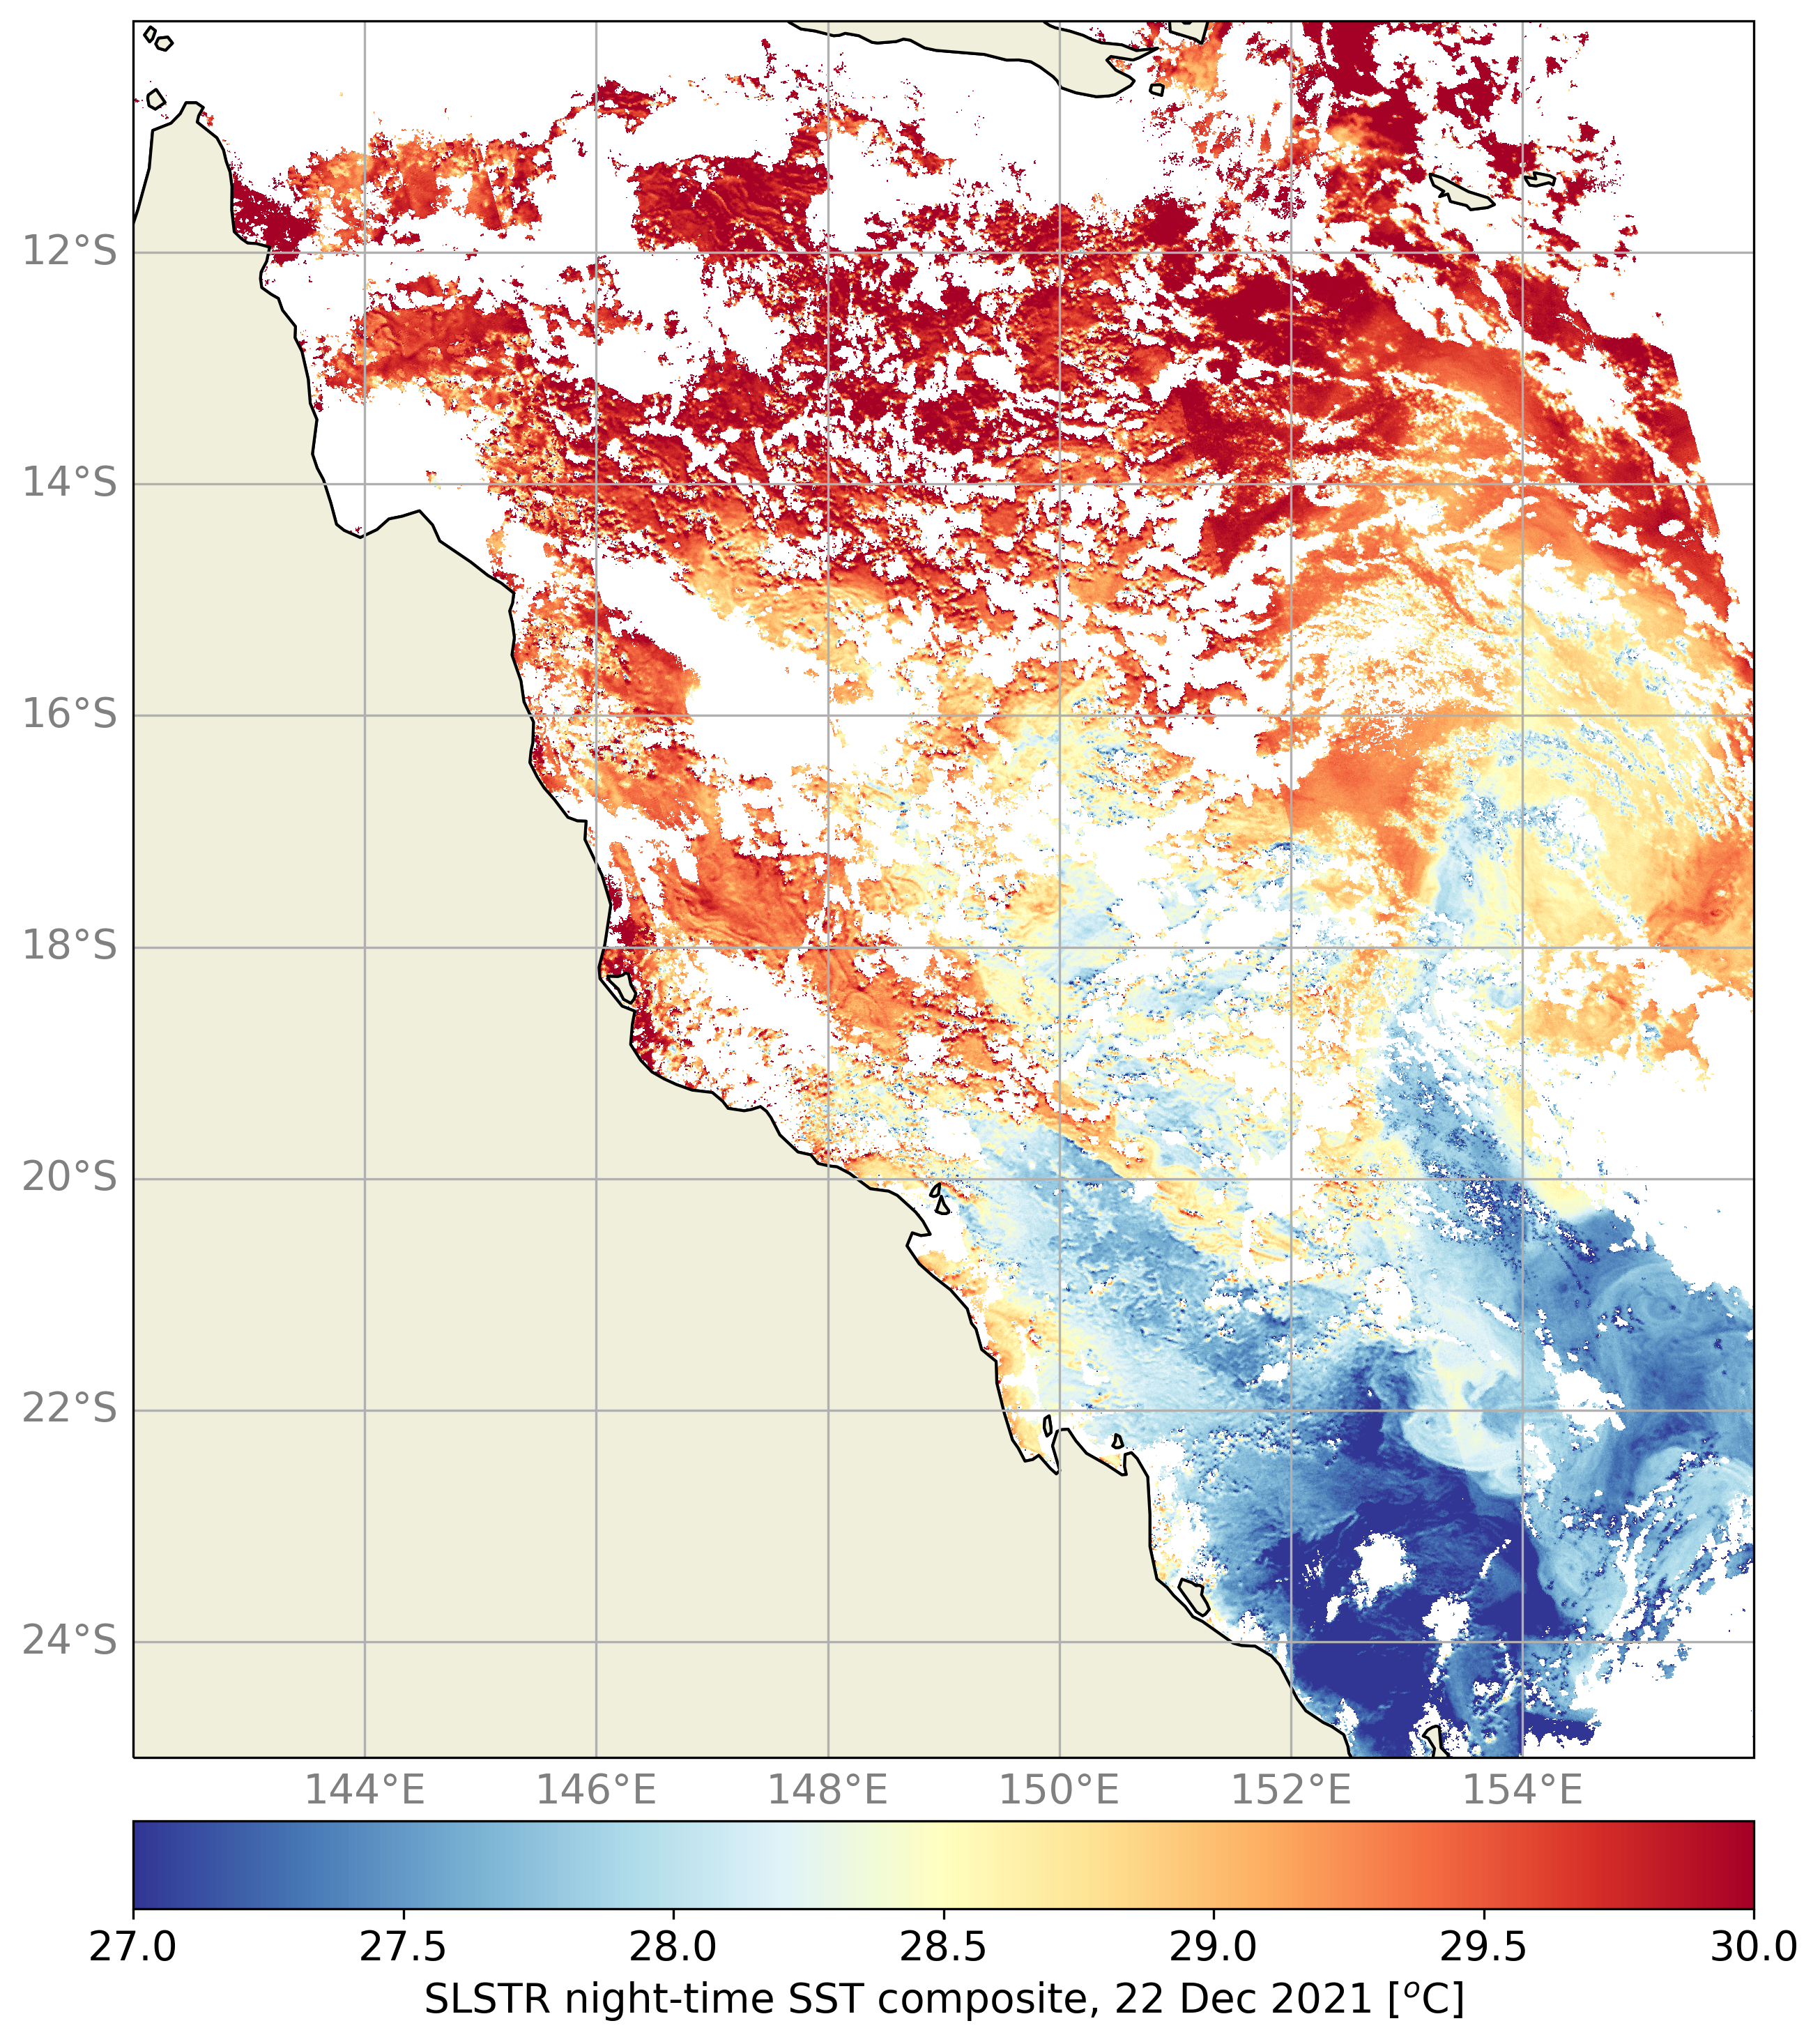

In [11]:
# setup figure
fig = plt.figure(figsize=(10, 12), dpi=300)
plt.rc('font', size=14)

# setup axes
gs = gridspec.GridSpec(3, 1, height_ratios=[20,0.5,1])
gs.update(wspace=0.01, hspace=0.01)

# setup plot 1: the composite
axes_m = plt.subplot(gs[0,0], projection=ccrs.PlateCarree())
axes_m.set_extent(plot_region)

# make the plot: we will call this as a function as it contains a 'for' loop to make the plot
for SLSTR_file in SLSTR_files:
    nc_fid = nc.Dataset(SLSTR_file)
    # plot the SST field
    SST = nc_fid.variables["sst"][:]
    SST[SST == 0] = np.nan
    p1 = axes_m.pcolormesh(nc_fid.variables["lon"], nc_fid.variables["lat"],
                           SST, cmap=plt.cm.RdYlBu_r,\
                           vmin=27, vmax=30, zorder=-1)
    nc_fid.close()

# add some map final embelishments
axes_m.coastlines(resolution='50m', color='black', linewidth=1)
axes_m.add_feature(ccf.NaturalEarthFeature('physical', 'land', '50m',
                                         edgecolor='k', facecolor=ccf.COLORS['land']))
g1 = axes_m.gridlines(draw_labels = True)
g1.top_labels = g1.right_labels = False
g1.xlabel_style = g1.ylabel_style = {'color': 'gray'}

# setup plot2: colorbar
axes_c = plt.subplot(gs[2,0])
cbar = plt.colorbar(p1, cax=axes_c, orientation='horizontal')
cbar.ax.tick_params() 
cbar.set_label('SLSTR night-time SST composite, 22 Dec 2021 [$^{o}$C]')
plt.savefig('SLSTR_composite_22122021.png', bbox_inches='tight')

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Downloading OSTIA SST data via the WEkEO HDA
[Back to top](#TOC_TOP)

</div>

Set query

In [12]:
query = {
  "datasetId": "EO:MO:DAT:SST_GLO_SST_L4_REP_OBSERVATIONS_010_011:METOFFICE-GLO-SST-L4-REP-OBS-SST",
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": ""
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": "",
      "end": ""
    }
  ],
  "multiStringSelectValues": [
    {
      "name": "variable",
      "value": [
        "analysed_sst"
      ]
    }
  ],
  "stringChoiceValues": [
    {
      "name": "service",
      "value": "SST_GLO_SST_L4_REP_OBSERVATIONS_010_011-TDS"
    },
    {
      "name": "product",
      "value": "METOFFICE-GLO-SST-L4-REP-OBS-SST"
    }
  ]
}

Download the data in 5-year blocks to avoid the data request limit

In [15]:
for START_YEAR in range(start_year, end_year, iter_year):
    query["dateRangeSelectValues"][0]["start"] = f"{str(START_YEAR)}-01-01T00:00:00.000Z"
    query["dateRangeSelectValues"][0]["end"] = f"{str(START_YEAR + iter_year - 1)}-12-31T00:00:00.000Z"
    query["boundingBoxValues"][0]["bbox"] = MHW_region

    print(f'From: {query["dateRangeSelectValues"][0]["start"]}')
    print(f'To:   {query["dateRangeSelectValues"][0]["end"]}')
    c = Client()
    matches = c.search(query)
    matches.download()

From: 1992-01-01T00:00:00.000Z
To:   1996-12-31T00:00:00.000Z


2022-07-25 13:29:45,721 WARNING Recovering from HTTP error [500 INTERNAL SERVER ERROR], attemps 0 of 500
2022-07-25 13:29:45,722 WARNING Retrying in 120 seconds


KeyboardInterrupt: 

In [ ]:
for item in glob.glob("*.nc"):
    os.rename(item, os.path.join(download_dir,item))

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Preparing the OSTIA data
[Back to top](#TOC_TOP)

</div>

Manipulate netCDF (trusting x-array a lot here!). These processes are lazy...

In [ ]:
SST_data = xr.open_mfdataset(glob.glob(os.path.join(download_dir,'METOFFICE-GLO*.nc')))
SST_spatial_average = SST_data.mean(dim='lat').mean(dim='lon')
SST_annual_values = SST_spatial_average.groupby('time.year').mean('time')
SST_anomaly = SST_annual_values["analysed_sst"] - SST_annual_values["analysed_sst"].mean(dim="year")

This calculates, so its a little slow...

In [ ]:
SST_stripes = np.squeeze(np.array(SST_anomaly))
SST_time_series = SST_spatial_average["analysed_sst"].load() - 273.15

<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Making SST-based climate stripes
[Back to top](#TOC_TOP)

</div>

Make a plottable array for the stripe

In [ ]:
SST_stripes_2D = np.repeat(SST_stripes[np.newaxis,...], 2, axis=0)

Plot

In [ ]:
fig = plt.figure(figsize=(25, 7))
plt.rc('font', size=18)

vmax = np.nanmax(abs(SST_stripes))

date_ticks = []
for ii in range(len(SST_anomaly)):
    date_ticks.append(str(start_year+ii))
    
plt.pcolormesh(SST_stripes_2D, vmin=vmax*-1, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.xticks(np.arange(len(SST_anomaly))+0.5, date_ticks, rotation='90', fontsize=20)
plt.xlim([0,len(SST_anomaly)])
plt.yticks([],[], fontsize=12)
cbar = plt.colorbar()
cbar.set_label('SST anomaly [$^{o}$C]',fontsize=20)
plt.savefig('Climate_stripes_GBR.png', bbox_inches='tight')

<div class="alert alert-info" role="alert">

## <a id='section6'></a>6. Testing for marine heatwaves
[Back to top](#TOC_TOP)

</div>

Set the correct date and time format

In [ ]:
times = [datetime.datetime.strptime(str(i), "%Y-%m-%dT%H:%M:%S.%f000").toordinal() 
           for i in np.asarray(SST_spatial_average["time"])]

doy = [datetime.datetime.strptime(str(i), "%Y-%m-%dT%H:%M:%S.%f000").timetuple().tm_yday - 1
       for i in SST_spatial_average["time"].values]

dates = [datetime.datetime.fromordinal(tt) for tt in times]

Run the heat wave calculations

In [ ]:
clim = threshold(SST_time_series)
mhws = detect(SST_time_series, clim['thresh'], clim['seas'])
rolling_clim_seas = np.array([i for ii in clim['seas'].values[doy] for i in ii])
rolling_clim_thresh = np.array([i for ii in clim['thresh'].values[doy] for i in ii])

In [ ]:
n_events = len(mhws['event'])
print(f"Number of heatwaves: {n_events}")
ev = 41 # zero indexed!

In [ ]:
plt.figure(figsize=(14, 10))
plt.rc('font', size=14)

p1, = plt.plot(SST_spatial_average["time"], rolling_clim_seas, 'b--', linewidth=1, zorder=1)
p2, = plt.plot(SST_spatial_average["time"], rolling_clim_thresh, 'r', linewidth=1, zorder=2)
p3, = plt.plot(SST_spatial_average["time"], SST_time_series, 'k', linewidth=1, zorder=3)

# Find indices for previous MHW and shade
for ev0 in np.arange(ev-10, min(ev+10, n_events), 1):
    t1 = np.where(SST_spatial_average["time"]==mhws['time_start'][ev0].values)[0][0]
    t2 = np.where(SST_spatial_average["time"]==mhws['time_end'][ev0].values)[0][0]
    if ev0 == ev:
        plot_col = 'r'
    else:
        plot_col = (1,0.6,0.5)
    plt.fill_between(np.array(dates[t1:t2+1]), rolling_clim_thresh[t1:t2+1], np.array(SST_time_series[t1:t2+1]), \
                     color=plot_col)

plt.xlim(SST_spatial_average["time"][-1000], SST_spatial_average["time"][-1])
plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + 2)
plt.ylabel(r'SST [$^\circ$C]')
plt.legend([p1, p2, p3],["Seasonal climatology", "Threshold", "SST"], frameon=False)
plt.savefig('Marine_heat_waves_GBR.png', bbox_inches='tight')

<hr>
<a href="../../../Index.ipynb"><< Index</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/applications/ocean-case-studies">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>